Changes to make:

create RC file for this
change to HDF5 datasets
move as much analysis as possible to other notebooks

### Imports

In [135]:
%matplotlib notebook
import matplotlib as mpl
mpl.style.use('paper.rc')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np
import os, glob
import data_tools as dt

In [2]:
%load_ext autoreload
%autoreload 2

### Directories

In [3]:
data_dir = os.path.join('./raw_data')
analysis_dir = os.path.join('./analysis')
fig_dir = os.path.join('./figures')

### Constants

Determined in `characterize_dot.ipynb`

In [4]:
MU_B = 5.7883818012e-5 # eV/T
K_B = 8.6173303e-5 # eV/K

ALPHA1_CLSD = 0.0469
ALPHA1_OPN = 0.0295
G1_OPN = 0.417
ALPHA2_CLSD = 0.0442
ALPHA2_OPN = 0.0333
G2_OPN = 0.400
ALPHA3_CLSD = 0.0415
ALPHA3_CLSD = 0.0265

# Figure 1

<IPython.core.display.Javascript object>


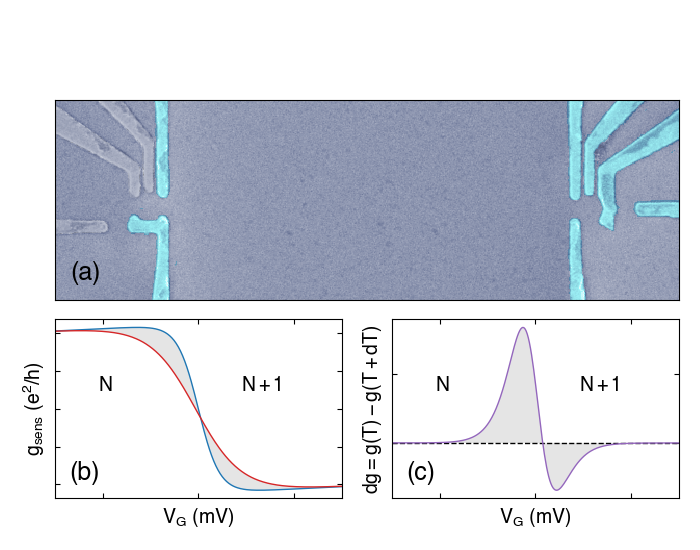

In [136]:
### setup figure
fig = plt.figure(figsize=(7,5.5))

gs1 = gridspec.GridSpec(2, 2, height_ratios = [2, 1])
ax0 = fig.add_subplot(gs1[0:1,:])
ax1 = fig.add_subplot(gs1[1,0])
ax2 = fig.add_subplot(gs1[1,1], sharex=ax1)

############################
### display device image ###
############################

ax0.imshow(mpl.image.imread(os.path.join(fig_dir,'device_cropped.png')))
ax0.set_xticks([])
ax0.xaxis.set_major_formatter(plt.NullFormatter())
ax0.set_yticks([])
ax0.yaxis.set_major_formatter(plt.NullFormatter())

##########################
### fake g and dg data ###
##########################

V0 = -487.5 # mV
dV0 = -0.69*K_B/(0.04)*50
beta1 = 0.55 # mV
beta2 = 1.2 # mV

xnew = np.linspace(-494,-480, 500)
enew = (xnew-V0)*0.04*1000
g1 = dt.i_sense(xnew, V0, beta1, 0.045, 10e-4, 0.5)
g2 = dt.i_sense(xnew, V0+dV0, beta2, 0.045, 10e-4, 0.5)
ax1.plot(enew, g1, label='T', c='C0')
ax1.plot(enew, g2, label='T+dT', c='C3')
ax1.fill_between(enew, g1, g2, facecolor='C7', alpha=0.2)

dg = 1000*dt.di_sense_simple(xnew, V0, beta1, 0.01, 0.0, -0.69/2)
ax2.axhline(y=0, lw=1, c='k', ls='--')
ax2.plot(enew, dg, c='C4')
ax2.fill_between(enew, 0, dg, facecolor='C7', alpha=0.2)

ax1.set_xlim(-150,150)
ax1.set_xticklabels([])
ax1.set_xlabel('V$_G$ (mV)')
ax1.set_ylabel('g$_{sens}$ (e$^2$/h)')
ax2.set_xlabel('V$_G$ (mV)')
ax2.set_ylabel('$dg = g(T) - g(T+dT)$')
ax1.set_yticklabels([])
ax2.set_yticklabels([])

ax1.text(0.15, 0.6, r'$N$', transform=ax1.transAxes)
ax1.text(0.65, 0.6, r'$N+1$', transform=ax1.transAxes)
ax2.text(0.15, 0.6, r'$N$', transform=ax2.transAxes)
ax2.text(0.65, 0.6, r'$N+1$', transform=ax2.transAxes)

gs1.tight_layout(fig, h_pad=-2, w_pad=1)

dt.add_subplot_id(ax0, 'a', loc = (0.025, 0.1)) # fix default font size
dt.add_subplot_id(ax1, 'b', loc = (0.05, 0.1))
dt.add_subplot_id(ax2, 'c', loc = (0.05, 0.1))

# fig.savefig(os.path.join(save_dir, 'figure_1_no-annotation.pdf'))

# Figure 2

<IPython.core.display.Javascript object>


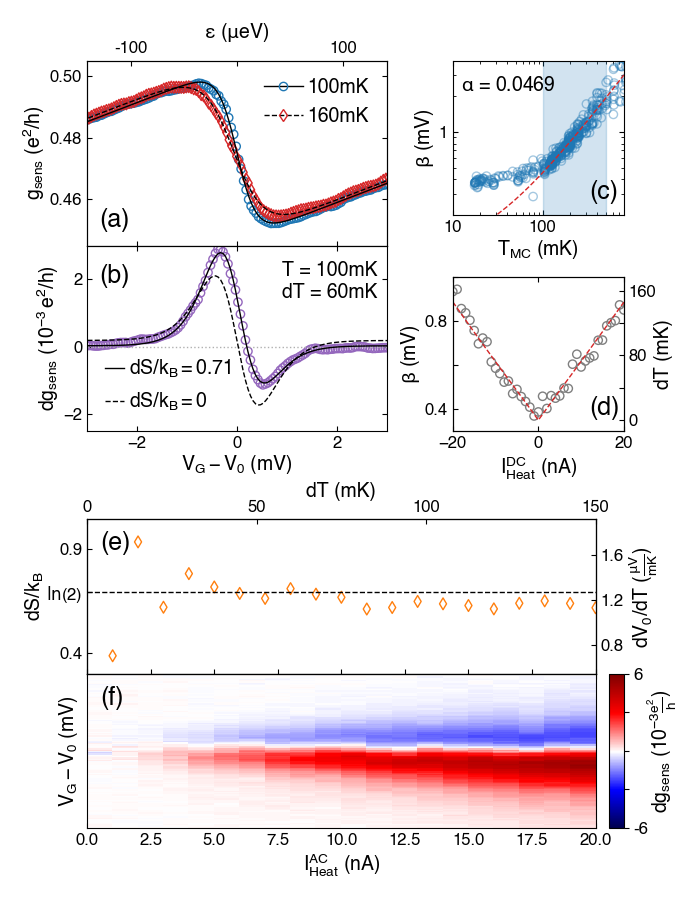

In [140]:
### setup figure

fig = plt.figure(figsize=(7,9))
outer = gridspec.GridSpec(2, 2, height_ratios = [1.2, 1], width_ratios = [1.75,1])

gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0,0],
                                       height_ratios = [1, 1], hspace=0)
ax0 = fig.add_subplot(gs1[0,0]) # g vs gate
ax1 = fig.add_subplot(gs1[1,0]) # dg vs gate

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0,1], hspace=0.4)
ax2 = fig.add_subplot(gs2[0]) # alpha calibration
ax3 = fig.add_subplot(gs2[1]) # beta/dT calibration

gs3 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[1,:],
                                       width_ratios = [1,0.03], hspace = 0, wspace=0.05)
ax4 = fig.add_subplot(gs3[0,0]) # dS vs I/dT
ax5 = fig.add_subplot(gs3[1,0]) # dg vs I/dT vs gate
cax = fig.add_subplot(gs3[1,1]) # colorbar

#################
### g vs gate ###
#################

swp = dt.open_hdf5(944, path=data_dir) # load sweep data
x, z = dt.moving_avg(0.5*swp['x_array'][:], swp['i_sense_dc2d'][:]*1e9, 5, axis=1)
i_results = pd.read_csv(os.path.join(analysis_dir, 'dat944_i_results.csv'))

x20 = i_results.loc[20,'x0']
ax0.scatter(x-x20, z[20]*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
            marker='o', facecolor='none', edgecolor='C0')
ax0.scatter(x-x20, z[28]*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
            marker='d', facecolor='none', edgecolor='C3')

ax0.plot(x-x20, dt.i_sense(x, *i_results.iloc[20,:-3].values)*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
         c='k', ls='-')
ax0.plot(x-x20, dt.i_sense(x, *i_results.iloc[28,:-3].values)*(1e-9)/(35e-3*1e-2)/(3.874e-5), 
         c='k', ls='--')

ax0.set_xlim(-3,3)
ax0.set_xticklabels([])
ax0.set_ylim(0.445, 0.505)
ax0.set_ylabel('g$_{sens}$ $(e^2/h)$')

# add energy axis to top of plot
ax0a = ax0.twiny()
eps = [-100, 0, 100]
vgs = [ep/ALPHA1_CLSD/1000 for ep in eps]
ax0a.set_xlim(ax0.get_xlim())
ax0a.set_xticks(vgs)
ax0a.set_xticklabels(['-100', '', '100'])
ax0a.set_xlabel('$\epsilon$ ($\mu eV$)')

# create legend
line_cold = mpl.lines.Line2D([], [], color='k', ls='-', lw=1, 
                              marker = 'o', markerfacecolor='none', markeredgecolor='C0', 
                              label='100mK')
line_hot = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'd', markerfacecolor='none', markeredgecolor='C3', 
                              label='160mK')

handles = [line_cold, line_hot]
labels = [h.get_label() for h in handles] 

ax0.legend(handles=handles, labels=labels,
              loc='upper right', numpoints=1,
              handletextpad=0.25, frameon=False)

# illustrate beta for T and T+dT
# ax1.plot([-beta1*40, beta1*40], [0.505, 0.505], marker='|', c='C0', lw=1)
# ax1.plot([-beta2*40, beta2*40], [0.49, 0.49], marker='|', c='C3', lw=1)
# ax1.text(beta1*40-8, 0.51, r'$2\beta(T)$', fontsize=13)
# ax1.text(beta2*40-8, 0.495, r'$2\beta(T+dT)$', fontsize=13)

##################
### dg vs gate ###
##################

swp = dt.open_hdf5(945, path=data_dir) 
x, z = dt.moving_avg(0.5*swp['x_array'][:], swp['g5x2d'][:], 5, axis=1)
z = z*(1e-8)*(1e9) # nA

di_free = pd.read_csv(os.path.join(analysis_dir, 'dat945_di_free_fits.csv'))
di_zero = pd.read_csv(os.path.join(analysis_dir, 'dat945_di_zero_fits.csv'))

ax1.axhline(y=0, lw=1, c='#b0b0b0', ls=':')
ax1.scatter(x-di_free.loc[8,'x0'], z[8]*(1e-6)/(35e-3*1e-2)/(3.874e-5), 
                marker='o', facecolors='none', edgecolors='C4')

ax1.plot(x-di_free.loc[8,'x0'], 
             (1e-6)*dt.di_sense_simple(x, *di_free.iloc[8,5:].values)/(35e-3*1e-2)/(3.874e-5), 
                 c='k', label=r'$dS/k_B = {0:.2f}$'.format(di_free.loc[8,'delta']*-2.0))
ax1.plot(x-di_zero.loc[8,'x0'], 
             (1e-6)*dt.di_sense_simple(x, *di_zero.iloc[8,5:].values)/(35e-3*1e-2)/(3.874e-5), 
                 c='k', ls='--', label=r'$dS/k_B = 0$')

ax1.legend(loc='lower left', numpoints=1,
           handletextpad=0.25, handlelength=1, 
           frameon=False)

ax1.set_xlim(-3,3)
ax1.set_ylabel('dg$_{sens}$ $(10^{-3} \, e^2/h)$')
ax1.set_xlabel('$V_G-V_0$ (mV)')
ax1.set_ylim(-2.5, 3.0)

ax1.text(0.65, 0.6, 'T = 100mK\ndT = 60mK\n', transform=ax1.transAxes)

############################################
### lever arm measurement for closed dot ###
############################################

datafiles = ['lever-arm_peak1_dataset_{0:d}.csv'.format(i+1) for i in range(3)]
df = pd.concat((pd.read_csv(os.path.join(analysis_dir,f)) for f in datafiles), ignore_index=True)
df.sort_values(by='Tmc', ascending=True, inplace=True)

ax2.scatter(df['Tmc'], df['beta'], 
                marker='o', facecolor='none', edgecolor='C0', alpha=0.4)
ax2.axvspan(100, 500, alpha=0.2, color='C0')

tnew  = np.loadtxt(os.path.join(analysis_dir,'peak1_alpha-fit_temps.csv'),delimiter=",")
betas = np.loadtxt(os.path.join(analysis_dir,'peak1_alpha-fit_betas.csv'),delimiter=",")
ax2.plot(tnew, betas, c='C3', ls='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(10, 800)
ax2.set_ylim(0.2, 4.0)
ax2.set_yticks([1])
ax2.set_yticklabels(['1'])
ax2.set_xticks([10, 100])
ax2.set_xticklabels(['10', '100'])
ax2.set_ylabel(r'$\beta$ (mV)')
ax2.set_xlabel('T$_{MC}$ (mK)')

ax2.text(0.05, 0.8, r'$\alpha$ = {0:.4f}'.format(ALPHA1_CLSD), transform=ax2.transAxes)

###########################
### beta/dT calibration ###
###########################

i_results = pd.read_csv(os.path.join(analysis_dir, 'dat944_i_results.csv'))
ax3.scatter(i_results['i_heat'], i_results['beta'], 
           marker='o', facecolors='none', edgecolors='C7')

ax3.set_xlim(-20,20)
ax3.set_ylim(0.3, 1.0)
ax3.set_yticks([0.4, 0.6, 0.8, 1.0])
ax3.set_yticklabels(['0.4', '', '0.8', ''])
ax3.set_xlabel(r'$I^{DC}_{Heat}$ (nA)')
ax3.set_ylabel(r'$\beta$ (mV)')

popt = np.loadtxt(os.path.join(analysis_dir, 'dat944_PtoBeta_fit.csv'), delimiter=',')
beta_calc = dt.line(np.sqrt(i_results['p_heat']), *popt)
ax3.plot(i_results['i_heat'], beta_calc, c='C3', ls='--')

ax3a = ax3.twinx()
dTs = [0, 40, 80, 120, 160]
T_min = (ALPHA1_CLSD*popt[1]/(2*K_B))
betas = [2*K_B*(dT+T_min)/ALPHA1_CLSD for dT in dTs]
ax3a.set_ylim(ax3.get_ylim())
ax3a.set_yticks(betas)
ax3a.set_yticklabels(['0', '', '80', '', '160'])
ax3a.set_ylabel(r'dT (mK)', labelpad=-2)

####################
### dS vs P plot ###
####################

di_results = pd.read_csv(os.path.join(analysis_dir, 'dat945_di_free_fits.csv'))
ax4.scatter(di_results['i_heat'], -2*di_results['delta'], 
                    marker='d', facecolors='none', edgecolors='C1')
ax4.axhline(y=1*np.log(2), ls='--', c='k', lw=1)
ax4.set_ylabel('dS/k$_B$', labelpad=0)
ax4.set_ylim(0.3, np.log(2)*1.5)
ax4.set_yticks([0.4, np.log(2), 0.9])
ax4.set_yticklabels(['0.4', '$\ln(2)$', '0.9'])
ax4.set_xlim(0,20)
ax4.set_xticklabels([])

# add second axis for dS vs dT
ax4a = ax4.twiny()
dTs = [0, 50, 100, 150]
betas = [2*K_B*(d+di_results['t_calc'][0])/ALPHA1_CLSD for d in dTs]
popt = np.loadtxt(os.path.join(analysis_dir, 'dat944_PtoBeta_fit.csv'), delimiter=',')
pwrs = [((b-popt[1])/popt[0])**2 for b in betas]
gqpc = (di_results['i_heat'].values/di_results['v_heat'].values).mean()
currents = [np.sqrt(p*1000*gqpc) for p in pwrs]
ax4a.set_xlim(ax4.get_xlim())
ax4a.set_xticks(currents)
ax4a.set_xticklabels(dTs)
ax4a.set_xlabel(r'dT (mK)')

ax4b = ax4.twinx()
dVdT = [0.0008, 0.0012, 0.0016]
dS = [v*ALPHA1_CLSD/K_B for v in dVdT]
ax4b.set_ylim(ax4.get_ylim())
ax4b.set_yticks(dS)
ax4b.set_yticklabels(['0.8', '1.2', '1.6'])
ax4b.set_ylabel(r'$dV_0$/$dT$ $(\frac{\mu V}{mK})$')

############################
### dg vs I_heat vs gate ###
############################

# dat = 945
# xmult = [2e-8, 0.5] # I_ac in Amps, plunger in mV

### import di_sense ###
swp = dt.open_hdf5(945, path=data_dir) 
x = swp['x_array'][:]*0.5 # mV
y = swp['y_array'][:]*2e-8*1e9 # nA
z = swp['g5x2d'][:]*(1e-8)*(1e9) # nA
z = z*(1e-6)/(35e-3*1e-2)/(3.874e-5) # 1e-3*e^2/h

vmin = -6; vmid = 0.0; vmax = 6
midpoint = 1 - np.abs(vmid-vmin)/np.abs(vmax-vmin)
cdmap = dt.shiftedColorMap(plt.cm.seismic, midpoint=midpoint, name='shiftedcmap')

im = ax5.pcolormesh(y, x-di_results.loc[8,'x0'], 
                        z.transpose(), cmap=cdmap, vmin=vmin, vmax=vmax)
ax5.set_xlim(0,20)
ax5.set_ylim(-3,3)
ax5.set_yticks([-2,0,2])
ax5.set_xlabel('I$^{AC}_{Heat}$ (nA)')
ax5.set_ylabel('$V_G-V_0$ (mV)')

################
### colorbar ###
################

cb = fig.colorbar(cax = cax, mappable = im, orientation = 'vertical', ticklocation = 'right')
cb.set_ticks([-6, -3, 0, 3, 6])
cb.set_ticklabels(['-6','','','','6'])
cb.set_label(r'dg$_{sens}$ $(10^{-3} \frac{e^2}{h})$', labelpad=-2)
cb.ax.tick_params(axis='y', direction='out')

outer.tight_layout(fig, w_pad=0.4, h_pad=0)

dt.add_subplot_id(ax0, 'a', loc = (0.04, 0.1))
dt.add_subplot_id(ax1, 'b', loc = (0.04, 0.8))
dt.add_subplot_id(ax2, 'c', loc = (0.8, 0.1))
dt.add_subplot_id(ax3, 'd', loc = (0.8, 0.1))
dt.add_subplot_id(ax4, 'e', loc = (0.025, 0.8))
dt.add_subplot_id(ax5, 'f', loc = (0.025, 0.8))

# fig.savefig(os.path.join(save_dir, 'figure_2.pdf'))

# Figure 3

<IPython.core.display.Javascript object>


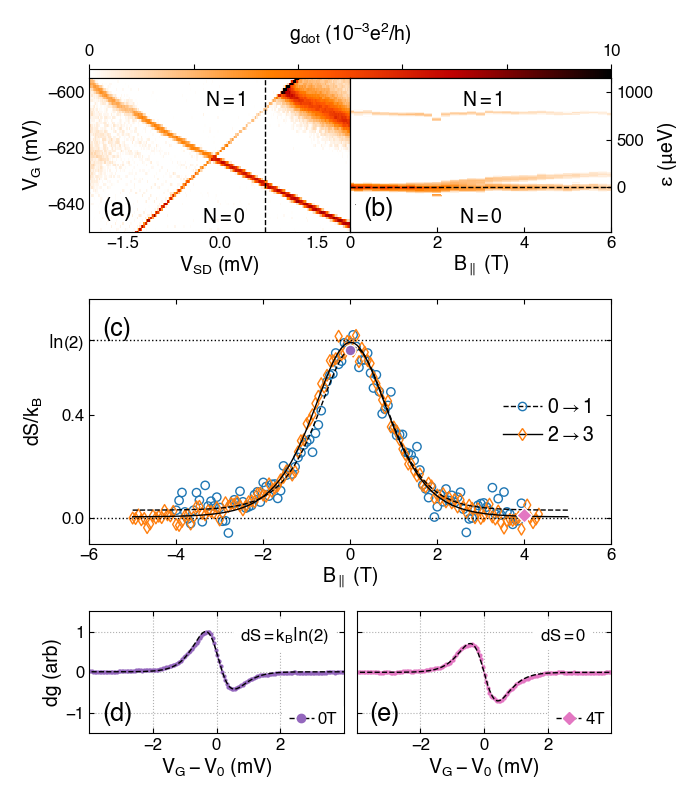

In [143]:
### setup figure ###
fig = plt.figure(figsize=(7,8))

outer = gridspec.GridSpec(3, 1, height_ratios = [1, 1.5, 0.75])

gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[0],
                                       height_ratios = [0.06, 1], wspace=0, hspace=0)
cax = fig.add_subplot(gs1[0,:])
ax0 = fig.add_subplot(gs1[1,0])
ax1 = fig.add_subplot(gs1[1,1])

gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
ax2 = fig.add_subplot(gs2[:])

gs3 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[2], wspace=0.05)
ax3 = fig.add_subplot(gs3[0])
ax4 = fig.add_subplot(gs3[1])

###############
### dS vs B ###
###############

### plot 01 data ###
df = pd.read_csv(os.path.join(analysis_dir, 'dat1011_di_free_fits.csv'))
ax2.scatter(df['field'], -2.0*df['delta'], 
               marker='o', facecolors='none', edgecolors='C0')

field = np.loadtxt(os.path.join(analysis_dir, 'dat1011_field.csv'))
dS = np.loadtxt(os.path.join(analysis_dir, 'dat1011_dS01_fit.csv'))
ax2.plot(field, dS, c='k', ls='--', lw=1)

### plot 23 data ###
df = pd.read_csv(os.path.join(analysis_dir, 'dat1442_di_free_fits.csv'))
ax2.scatter(df['field'], -2.0*df['delta'], 
               marker='d', facecolors='none', edgecolors='C1')

field = np.loadtxt(os.path.join(analysis_dir, 'dat1442_field.csv'))
dS = np.loadtxt(os.path.join(analysis_dir, 'dat1442_dS23_fit.csv'))
ax2.plot(field, dS, c='k', ls='-', lw=1)

ax2.axhline(y=np.log(2), color='k', linestyle=':')
ax2.axhline(y=0, color='k', linestyle=':')

ax2.set_xlim(-6, 6)
ax2.set_ylim(-0.1, 0.85)

line01 = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'o', markerfacecolor='none', markeredgecolor='C0', 
                              label=r'$0 \rightarrow 1$')
line23 = mpl.lines.Line2D([], [], color='k', lw=1, 
                              marker = 'd', markerfacecolor='none', markeredgecolor='C1', 
                              label=r'$2 \rightarrow 3$')

handles = [line01, line23]
labels = [h.get_label() for h in handles] 

ax2.legend(handles=handles, labels=labels,
              loc='center right', numpoints=1,
              handletextpad=0.25, frameon=False)

ax2.set_ylabel('dS/k$_B$')
ax2.set_yticks([0.0, 0.4, np.log(2)])
ax2.set_yticklabels(['0.0', '0.4', r'$\ln(2)$'])
ax2.set_xlabel('B$_{\parallel}$ (T)')

#############################
### markers for line cuts ###
#############################

df = pd.read_csv(os.path.join(analysis_dir, 'dat1011_di_free_fits.csv'))
ax2.scatter(df.loc[60,'field'], -2.0*df.loc[60,'delta'], marker='o', s=60, zorder=3, 
            facecolors='C4', edgecolors='w')
ax2.scatter(df.loc[120,'field'], -2.0*df.loc[120,'delta'], marker='D', s=60, zorder=3, 
            facecolors='C6', edgecolors='w')

##########################
### dg at B=0 and B=4T ###
##########################

swp = dt.open_hdf5(1011, path=data_dir) # load sweep data
vy = swp['y_array'][:]/1000.0
vx, vz = dt.moving_avg(swp['x_array'][:]*0.5, swp['g5x2d'][:]*2e-8, 5, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h

ax3.plot(vx-df.iloc[60,0], vz[60]/np.abs(vz[60]).max(), marker='.', markersize=4, c='C4')
di_fit = dt.di_sense_simple(vx, *df.iloc[60,:-1].values)
ax3.plot(vx-df.iloc[60,0], di_fit/np.abs(di_fit).max(), c='k', ls='--')
ax3.text(0.94, 0.76, r'$dS=k{_B}\ln(2)$', fontsize=12,
         transform=ax3.transAxes, ha='right', backgroundcolor='w')
line0T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'o', markerfacecolor='C4', markeredgecolor='C4', 
                              label='0T')
handles = [line0T]
labels = [h.get_label() for h in handles] 
ax3.legend(handles=handles, labels=labels, fontsize = 12,
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

ax4.plot(vx-df.iloc[120,0], vz[120]/np.abs(vz[120]).max()/np.sqrt(2), marker='.', markersize=4, c='C6')
di_fit = dt.di_sense_simple(vx, *df.iloc[120,:-1].values)
ax4.plot(vx-df.iloc[120,0], di_fit/np.abs(di_fit).max()/np.sqrt(2), c='k', ls='--')
ax4.text(0.90, 0.76, r'$dS=0$', fontsize=12,
         transform=ax4.transAxes, ha='right', backgroundcolor='w')
line4T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'D', markerfacecolor='C6', markeredgecolor='C6', 
                              label='4T')
handles = [line4T]
labels = [h.get_label() for h in handles] 
ax4.legend(handles=handles, labels=labels, fontsize=12,
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

for a in[ax3, ax4]:
    a.set_xlim(-4,4)
    a.set_xticks([-2,0,2])
    a.set_ylim(-1.5, 1.5)
    a.set_yticks([-1, 0, 1])
    a.grid(ls=':')
    a.set_xlabel(r'$V_G-V_0$ (mV)')

ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax3.set_ylabel('dg (arb)')

#######################
### coulomb diamond ###
#######################

xmult = [0.01, 0.5] # bias mV, gate 10 mV

swp = dt.open_hdf5(1228, path=data_dir) # load sweep
xx, yy = dt.xy_to_meshgrid(swp['x_array'][:]*0.01, swp['y_array'][:]*0.5)
cond = swp['g_dot2d'][:]

vmin = 0.0; vmid = 3; vmax = 10
midpoint = 1 - np.abs(vmid-vmin)/np.abs(vmax-vmin)
cdmap = dt.shiftedColorMap(plt.cm.gist_heat_r, midpoint=midpoint, name='shiftedcmap')

im = ax0.pcolormesh(xx, yy, cond*1000, cmap=cdmap, vmin=vmin, vmax=vmax)
ax0.axvline(x=0.7, color='k', lw=1, ls='--')
ax0.set_xlabel('V$_{SD}$ (mV)')
ax0.set_ylabel('V$_{G}$ (mV)')
ax0.set_xticks([-1.5, 0, 1.5])
ax0.set_ylim(-650, -595)

ax0.text(0.4, -605, r'$N=1$', horizontalalignment='right')
ax0.text(0.4, -647, r'$N=0$', horizontalalignment='right')

################
### colorbar ###
################

cb = plt.colorbar(cax = cax, mappable = im, orientation = 'horizontal', ticklocation = 'top')
cb.set_ticks([0,2,4,6,8,10])
cb.set_ticklabels(['0','','','','','10'])
cb.set_label(r'g$_{dot}$ ($10^{-3}e^2$/h)')
cb.ax.tick_params(axis='x', direction='out')

#####################
### g factor data ###
#####################

swp = dt.open_hdf5(1232, path=data_dir) # load sweep
xplt = np.loadtxt(os.path.join(analysis_dir, 'dat1232_xplt.csv'), delimiter=',')
yplt = np.loadtxt(os.path.join(analysis_dir, 'dat1232_yplt.csv'), delimiter=',')
xshift = np.loadtxt(os.path.join(analysis_dir, 'dat1232_xshift.csv'), delimiter=',')
z = swp['g_dot2d'][:]*1000

for i in range(len(z)):
    xx, yy = np.meshgrid(np.array([yplt[i], yplt[i+1]]), 
                             (xplt - xshift[i])+xshift.mean())
    ax1.pcolormesh(xx, yy, z[i,None].transpose(), cmap=cdmap, vmin=vmin, vmax=vmax)  

ax1.axhline(y=xshift.mean(), c='k', ls='--', lw=1)

ax1.text(3.5, -605, r'$N=1$', horizontalalignment='right')
ax1.text(3.5, -647, r'$N=0$', horizontalalignment='right')
ax1.set_xlabel('B$_{\parallel}$ (T)')
ax1.set_ylim(-650, -595)
ax1.set_xlim(0, 6)
ax1.set_yticklabels([])

# add energy scale for y-axis
ax1a = ax1.twinx()
eps = [0, 500, 1000]
vgs = [ep/ALPHA1_OPN/1000+xshift.mean() for ep in eps]
ax1a.set_ylim(ax1.get_ylim())
ax1a.set_yticks(vgs)
ax1a.set_yticklabels(eps)
ax1a.set_ylabel('$\epsilon$ ($\mu eV$)')

outer.tight_layout(fig)

dt.add_subplot_id(ax0, 'a', loc = (0.05, 0.1))
dt.add_subplot_id(ax1, 'b', loc = (0.05, 0.1))
dt.add_subplot_id(ax2, 'c', loc = (0.025, 0.85))
dt.add_subplot_id(ax3, 'd', loc = (0.05, 0.1))
dt.add_subplot_id(ax4, 'e', loc = (0.05, 0.1))

# fig.savefig(os.path.join(save_dir, 'figure_3.pdf'))

# Figure 4

In [ ]:
### setup figure ###
fig = plt.figure(figsize=(6,7))

outer = gridspec.GridSpec(3, 1, height_ratios = [1, 1.5, 0.75])

gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[0],
                                       height_ratios = [0.06, 1], wspace=0, hspace=0)
cax = fig.add_subplot(gs1[0,:])
ax0 = fig.add_subplot(gs1[1,0])
ax1 = fig.add_subplot(gs1[1,1])

gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
ax2 = fig.add_subplot(gs2[:])

gs3 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = outer[2], wspace=0.05)
ax3 = fig.add_subplot(gs3[0])
ax4 = fig.add_subplot(gs3[1])
ax5 = fig.add_subplot(gs3[2])

###############
### dS vs B ###
###############

df = pd.read_pickle(os.path.join(save_dir, 'dat1284-1290_di_results'))
ax2.scatter(df['field']/1000.0, -2.0*df['delta'], 
               marker='o', s=25, facecolors='none', edgecolors='C0')

field = np.load(os.path.join(save_dir, 'dat1284-1290_fields.npy'))
dS = np.load(os.path.join(save_dir, 'dat1284-1290_dS12.npy'))
ax2.plot(field, dS, c='k', ls='--', lw=1)
ax2.axhline(y=np.log(2), color='k', linestyle=':', lw=1)
ax2.axhline(y=0, color='k', linestyle=':', lw=1)
ax2.axhline(y=-1*np.log(2), color='k', linestyle=':', lw=1)

ax2.set_xlim(-5, 11)
ax2.set_ylim(-0.85, 0.85)

line12 = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'o', markerfacecolor='none', markeredgecolor='C0', 
                              label=r'$1 \rightarrow 2$')
handles = [line12]
labels = [h.get_label() for h in handles] 

ax2.legend(handles=handles, labels=labels,
              loc='upper left', numpoints=1,
              handletextpad=0.25, frameon=False, 
              bbox_to_anchor=(0, 0.9))

ax2.set_ylabel('dS/k$_B$')
ax2.set_yticks([-1*np.log(2), -0.4, 0.0, 0.4, np.log(2)])
ax2.set_yticklabels([r'$-\ln(2)$', '-0.4', '0.0', '0.4', r'$\ln(2)$'])
ax2.set_xticks([-3,0,3,6,9])
ax2.set_xlabel('B$_{\parallel}$ (T)')

#############################
### markers for line cuts ###
#############################

df = pd.read_pickle(os.path.join(save_dir, 'dat1284-1290_di_results'))

ax2.scatter(df.loc[61,'field']/1000, -2.0*df.loc[61,'delta'], marker='s', s=60, zorder=3, 
            facecolors='C4', edgecolors='w')
ax2.scatter(df.loc[136,'field']/1000, -2.0*df.loc[136,'delta'], marker='o', s=60, zorder=3, 
            facecolors='C1', edgecolors='w')
ax2.scatter(df.loc[196,'field']/1000, -2.0*df.loc[196,'delta'], marker='D', s=60, zorder=3, 
            facecolors='C6', edgecolors='w')

#####################################
### dg at B=0 and B=5T and B=8.9T ###
#####################################

df = pd.read_pickle(os.path.join(save_dir, 'dat1284-1290_di_results'))

v = import_wave(1284, 'g5x2d', x_multiplier = [0.5, 0.001], y_multiplier=2e-8)
vy = v.x[:,0,1]
vx, vz = moving_avg(v.x[0,:,0], v.y, 5, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
vz = vz/np.abs(vz[61]).max()
ax3.scatter(vx-df.iloc[61,0], -vz[61], marker='.', s=10, label='0T', c='C4')
di_fit = di_sense_simple(vx, *df.iloc[61,:-1].values)
ax3.plot(vx-df.iloc[61,0], di_fit/np.abs(di_fit).max(), label='0T', c='k', ls='--', lw=1)
ax3.text(0.92, 0.80, r'$dS=-k_B \ln(2)$', 
         transform=ax3.transAxes, fontsize=10, ha='right', backgroundcolor='w')
line0T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 's', markerfacecolor='C4', markeredgecolor='C4', 
                              label='0T')
handles = [line0T]
labels = [h.get_label() for h in handles] 
ax3.legend(handles=handles, labels=labels, fontsize=10, 
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

v = import_wave(1285, 'g5x2d', x_multiplier = [0.5, 0.001], y_multiplier=2e-8)
vy = v.x[:,0,1]
vx, vz = moving_avg(v.x[0,:,0], v.y, 5, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
vz = vz/np.abs(vz[15]).max()/np.sqrt(2)
ax4.scatter(vx-df.iloc[136,0], -vz[15], marker='.', s=10, label='5T', c='C1')
di_fit = di_sense_simple(vx, *df.iloc[136,:-1].values)
ax4.plot(vx-df.iloc[136,0], di_fit/np.abs(di_fit).max()/np.sqrt(2), label='5T', c='k', ls='--', lw=1)
ax4.text(0.90, 0.80, r'$dS=0$', 
         transform=ax4.transAxes, fontsize=10, ha='right', backgroundcolor='w')
line5T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = 'o', markerfacecolor='C1', markeredgecolor='C1', 
                              label='5T')
handles = [line5T]
labels = [h.get_label() for h in handles] 
ax4.legend(handles=handles, labels=labels, fontsize=10, 
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

v = import_wave(1288, 'g5x2d', x_multiplier = [0.5, 0.001], y_multiplier=2e-8)
vy = v.x[:,0,1]
vx, vz = moving_avg(v.x[0,:,0], v.y, 5, axis=1)
vz = vz*(1e3)/(35e-3*1e-2)/(3.874e-5) # 0.001e^2/h
vz = vz/np.abs(vz[4]).max()
ax5.scatter(vx-df.iloc[196,0], -vz[4], marker='.', s=10, label='9T', c='C6', zorder=4)
di_fit = di_sense_simple(vx, *df.iloc[196,:-1].values)
ax5.plot(vx-df.iloc[196,0], di_fit/np.abs(di_fit).max(), label='9T', c='k', ls='--', lw=1, zorder=4)
ax5.text(0.94, 0.80, r'$dS=k_B \ln(2)$', 
         transform=ax5.transAxes, fontsize=10, ha='right', backgroundcolor='w')
line9T = mpl.lines.Line2D([], [], color='k', ls='--', lw=1, 
                              marker = '^', markerfacecolor='C6', markeredgecolor='C6', 
                              label='9T')
handles = [line9T]
labels = [h.get_label() for h in handles] 
ax5.legend(handles=handles, labels=labels, fontsize=10, 
            loc='lower right', borderaxespad=0,
            numpoints=1, handletextpad=0.25, handlelength=1.5, 
            frameon=True, facecolor='w', edgecolor='none', framealpha=1)

for a in[ax3, ax4, ax5]:
    a.set_xlim(-4,4)
    a.set_xticks([-2,0,2])
    a.set_ylim(-1.5, 1.75)
    a.set_yticks([-1, 0, 1])
    a.grid(ls=':')
    a.set_xlabel(r'$V_G-V_0$ (mV)')

ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax3.set_ylabel(r'dg (arb)')
ax4.set_xlabel(r'$V_G-V_0$ (mV)')

#######################
### coulomb diamond ###
#######################

dat = 1087
xmult = [0.01, 0.5] # bias mV, gate 10 mV

u = import_wave(dat, 'g_dot2d', x_multiplier=xmult)

vmin = -1; vmid = 3; vmax = 20
midpoint = 1 - np.abs(vmid-vmin)/np.abs(vmax-vmin)
cdmap = shiftedColorMap(plt.cm.gist_heat_r, midpoint=midpoint, name='shiftedcmap')

im = ax0.pcolormesh(u.x[:,:,0], u.x[:,:,1], u.y*1000, cmap=cdmap, vmin=vmin, vmax=vmax)
ax0.axvline(x=1.25, color='k', lw=1, ls='--')
ax0.set_xlabel('V$_{SD}$ (mV)')
ax0.set_ylabel('V$_{G}$ (mV)')
ax0.set_xticks([-1.0, 0, 1.0])
ax0.set_ylim(-725, -650)

ax0.text(0.3, -663, r'$N=2$', fontsize=15, horizontalalignment='right')
ax0.text(0.3, -720, r'$N=1$', fontsize=15, horizontalalignment='right')

# ax0.text(0.0, 0.0, 'r$\alpha = -{0:.3f}'.format(ALPHA1_OPN), fontsize=13)

####################
### add colorbar ###
####################

cb = plt.colorbar(cax = cax, mappable = im, orientation = 'horizontal', ticklocation = 'top')
cb.set_ticks([0, 5, 10, 15, 20])
cb.set_ticklabels(['0','','','','20'])
cb.set_label(r'g$_{dot}$ ($10^{-3}e^2$/h)', labelpad=-2)
cb.ax.tick_params(axis='x', direction='out')

##########################
### plot g factor data ###
##########################

dats = [1082, 1083, 1084]
n = [-5, None, None]
length = [26, 15, 5]
xmult = [0.5, 1e-3] # gate 10 in mV, field in T
dx = 62.5/300 # mV
dy = 0.2 # T

z_all = np.zeros((46,301))
xshift = np.zeros(46)
xypeaks = []
for i, dat in enumerate(dats):
    # import data
    w = import_wave(dat, 'g_dot2d', x_multiplier = xmult)
    x = w.x[0,:,0]
    y = w.x[:n[i],0,1]
    z = w.y[:n[i]]*1000
    z_all[sum(length[:i]):sum(length[:i+1]),:] = z

    # find peaks
    for j in range(len(z)):
        ipeak = peakutils.indexes(z[j], thres=0.2)
        xshift[sum(length[:i])+j] = x[ipeak[0]]
        for p in ipeak:
            xypeaks.append([x[p]-x[ipeak[0]], y[j]])
    
    # plot color map
    xlong = np.linspace(w.extent[0]-dx/2.0, w.extent[1]+dx/2.0, w.y.shape[1]+1)
    ylong = np.linspace(w.extent[2]-dy/2.0, w.extent[3]+dy/2.0, w.y.shape[0]+1)
    for j in range(len(z)):
        xsm = (xlong - xshift[sum(length[:i])+j])-702
        ysm = ylong[j], ylong[j+1]
        xx, yy = np.meshgrid(ysm, xsm) # create grid + flip axes

        ax1.pcolormesh(xx, yy, z[j].reshape(-1, 1), cmap=cdmap, vmin=vmin, vmax=vmax)  
            
xypeaks = np.array(xypeaks)
xypeaks[:,0] = 1000*xypeaks[:,0]*0.03329

mask = (xypeaks[:,0]>1.0) & (xypeaks[:,0]<400)
tpeaks = xypeaks[mask,:]

txplus = []
txzero = []
ty = []
for field in np.unique(tpeaks[:,1]):
    mask = (np.abs(tpeaks[:,1] - field) < 1e-6)
    if mask.sum()==2:
        ty.append(field)
        txplus.append(tpeaks[mask][:,0][0])
        txzero.append(tpeaks[mask][:,0][1])
        
ty = np.array(ty)
txzero = np.array(txzero)
txplus = np.array(txplus)
tx = np.stack((txplus, txzero))

def line_dataset(params, i, xx):

    a = params['a{0:d}'.format(i)]
    b = params['b{0:d}'.format(i)]

    return line(xx, a, b)
    
def line_objective(params, xx, yy):

    resid = []
    # make residual per data set
    for i in range(len(yy)):
        resid.append(yy[i,:] - line_dataset(params, i, xx))
    # now flatten this to a 1D array, as minimize() needs
    return np.concatenate(resid)

fit_params = Parameters()
fit_params.add('a0', value=20.0)
fit_params.add('b0', value=300.0)
fit_params.add('a1', value=20.0)
fit_params.add('b1', value=300.0)
fit_params['b1'].expr = 'b0'

m = minimize(line_objective, fit_params, args=(ty, tx))
valdict = m.params.valuesdict()

fields = np.linspace(0,9.6, 200)
ax1.plot(fields, line(fields, valdict['a0'], valdict['b0'])/0.03329/1000-702, c='k', ls=':', lw=1)
ax1.plot(fields, line(fields, valdict['a1'], valdict['b1'])/0.03329/1000-702, c='k', ls=':', lw=1)

ax1.text(5.5, -663, r'$N=2$', fontsize=15, horizontalalignment='right')
ax1.text(5.5, -720, r'$N=1$', fontsize=15, horizontalalignment='right')
# ax1.text(0.0, 0.0, 'g = -{0:.2f}'.format((valdict['a1']-valdict['a0'])/MU_B/1e6), fontsize=13)

ax1.set_xlabel('B$_{\parallel}$ (T)')
ax1.set_ylim(-725, -650)
ax1.set_xlim(0, 9)
ax1.set_xticks([0, 3, 6, 9])
ax1.set_yticklabels([])

ax1a = ax1.twinx()
eps = [-500, 0, 500, 1000]
vgs = [ep/0.03329/1000-702 for ep in eps]
ax1a.set_ylim(ax1.get_ylim())
ax1a.set_yticks(vgs)
ax1a.set_yticklabels(eps)
ax1a.set_ylabel('$\epsilon$ ($\mu eV$)')

outer.tight_layout(fig)
outer.update(hspace=0.42)

add_subplot_id(ax0, 'a', loc = (0.05,0.1), fontsize=15)
add_subplot_id(ax1, 'b', loc = (0.05,0.1), fontsize=15)
add_subplot_id(ax2, 'c', loc = (0.025,0.1), fontsize=15)
add_subplot_id(ax3, 'd', loc = (0.05,0.1), fontsize=15)
add_subplot_id(ax4, 'e', loc = (0.05,0.1), fontsize=15)
add_subplot_id(ax5, 'f', loc = (0.05,0.1), fontsize=15)

# fig.savefig(os.path.join(save_dir, 'figure_4.pdf'))